[View in Colaboratory](https://colab.research.google.com/github/zabiullakhangithub/Image_Classification_Project_2/blob/master/Image_Classification_Project_2.ipynb)

**Image Classification Project** In this project, you'll classify images from the CIFAR-10 dataset



#Step:1 Downloading data from source




In [4]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 3.3MB/s 
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from urllib.request import urlretrieve
from os.path import isfile,isdir
from tqdm import tqdm
import tarfile

    
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import random

In [0]:
cifar10_dataset_folder_path = 'cifar-10-batches-py'

In [0]:
class DLProgress(tqdm):
  last_block = 0
  
  def hook(self,block_num=1,block_size=1,total_size=None):
    self.total = total_size
    self.update((block_num-self.last_block)*block_size)
    self.last_block=block_num

In [8]:
if not isfile('cifar-10-python.tar.gz'):
  with DLProgress(unit='B',unit_scale=True,miniters=1,desc='CIFAR-10 Dataset') as pbar:
    urlretrieve('https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz','cifar-10-python.tar.gz',pbar.hook)
                
if not isdir(cifar10_dataset_folder_path):
    with tarfile.open('cifar-10-python.tar.gz') as tar:
        tar.extractall()
        tar.close()

CIFAR-10 Dataset: 171MB [00:22, 7.73MB/s]                           


# Step:2 Data Visualization

In [0]:
#function to unpickle images & label_names
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [0]:
#get label names from batches.meta file
label_names = unpickle("{}/batches.meta".format(cifar10_dataset_folder_path))
label_name_array=label_names[b'label_names']

In [0]:

#get images and label index from batch files#get ima 
batch_num = 5 ## values 1 to 5 only
data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))

data = data_label[b'data']
imgs=np.asanyarray(data).astype("uint8")

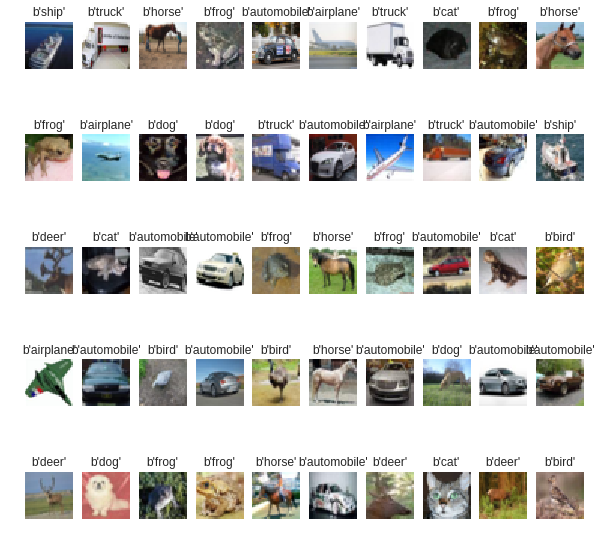

In [13]:
columns = 10
rows = 5
fig=plt.figure(figsize=(10, 10))

for i in range(1, columns*rows +1):
    num = random.randint(0,10000)
    one_img=imgs[num,:]
    img=one_img.reshape(3,32,32).transpose([1, 2, 0])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')
    fig.gca().grid(False)
    plt.title(label_name_array[int(data_label[b'labels'][num])])

# Step:3 Data Preprocessing & Saving

In [0]:
## Function to normalize image data## Funct 
## This is to convert RGB image to gray scale image of range 0 to 1
def normalize(x):
  return x/255  ## min value is 0 & max value is 255 for RGB

In [0]:
## Function for one-hot encoding 
def one_hot_encoding(x):
  return np.asarray(pd.get_dummies(x))

In [0]:
## Function to load batch from data set
def load_cifar10_batch(cifar10_dataset_folder_path,batch_num):
  data_label = unpickle("{}/data_batch_{}".format(cifar10_dataset_folder_path,batch_num))
  #print(data_label)
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

## Function to load test data from data set
def load_cifar10_test(cifar10_dataset_folder_path):
  data_label = unpickle("{}/test_batch".format(cifar10_dataset_folder_path))
  features = data_label[b'data'].reshape(len(data_label[b'data']),3,32,32).transpose(0,2,3,1)
  labels = data_label[b'labels']
  return features,labels

In [0]:
## Function to normalize features and perform one_hot_encoding on labels
def _preprocess_and_save(normalize,one_hot_encoding,features,labels,filename):
  features = normalize(features)
  labels = one_hot_encoding(labels)
  pickle.dump((features,labels),open(filename,'wb'))

In [0]:
## Function to preprocess,split and save Traing, Validation & Test Data
def preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding):
  
  num_batches = 5
  valid_features = []
  valid_labels = []
  
  for i in range (1,num_batches+1):
    
    # Load Data from batches
    features,labels = load_cifar10_batch(cifar10_dataset_folder_path,i)
    valid_count = int(len(features)*0.1)
    
    #print(features[:-valid_count])
    #To Save Traing Data
    _preprocess_and_save(normalize,one_hot_encoding,features[:-valid_count],labels[:-valid_count],"preprocess_batch_{}.p".format(i)) 
    
    # Validation Data from batch
    valid_features.extend(features[-valid_count:])
    valid_labels.extend(labels[-valid_count:])
  
  # To Save Validation Data
  _preprocess_and_save(normalize,one_hot_encoding,np.asarray(valid_features),np.asarray(valid_labels),"preprocess_validation.p".format(i))
  
  
  # To Save Test Data 
  
  features_test,labels_test = load_cifar10_test(cifar10_dataset_folder_path)
  _preprocess_and_save(normalize,one_hot_encoding,features_test,labels_test,"preprocess_test.p".format(i))

In [0]:
## Preprocess and save Train, Validation & Test Data
preprocess_and_save(cifar10_dataset_folder_path,normalize,one_hot_encoding)

In [20]:

!ls

cifar-10-batches-py	preprocess_batch_2.p  preprocess_test.p
cifar-10-python.tar.gz	preprocess_batch_3.p  preprocess_validation.p
datalab			preprocess_batch_4.p
preprocess_batch_1.p	preprocess_batch_5.p


# Step:4 Implementing Input Methods

In [0]:
## Function to return batch of Image Input
def neural_net_image_input(image_shape):
  return tf.placeholder(tf.float32,shape=(None,)+image_shape,name='x')

In [0]:
## Function to return batch of Label Input
def neural_net_label_input(n_classes):
  return tf.placeholder(tf.float32,shape=(None,n_classes),name='y')

In [0]:
## Function to return keep probability for drop outs## Funct 
def neural_net_keep_prob_input():
  return tf.placeholder(tf.float32,name='keep_prob')

# Step:5 Implementing Convolution and Max Pooling Layer

In [0]:
## This is to build Convolution and Max Pooling Layer
#x_tensor: input
#conv_num_outputs: Number of output from convolution layer
#conv_ksize : convolutional layer kernal size
#conv_strides : convolutionallayer Sride
#pool_ksize: max-pooling kernal size
#pool_strides: max-pooling srides 
#


def conv2d_maxpool(x_tensor,conv_num_outputs,conv_ksize,conv_strides,pool_ksize,pool_strides):
  
  ## To Caluculate weights and bias
  weights = tf.Variable(tf.truncated_normal([*conv_ksize,x_tensor.shape.as_list()[3],conv_num_outputs],stddev=5e-2))
  bias = tf.Variable(tf.zeros(conv_num_outputs))
  
  ## Convolution layer
  
  conv_layer = tf.nn.conv2d(x_tensor,weights,strides=[1,*conv_strides,1],padding='SAME')
  
  ## Add bias
  
  conv_layer = tf.nn.bias_add(conv_layer,bias)
  
  
  ## Add activation function
  
  conv_layer = tf.nn.relu(conv_layer)
  
  
  ## Add max-pooling 
  
  conv_layer = tf.nn.max_pool(conv_layer,ksize=[1,*pool_ksize,1],strides=[1,*pool_strides,1],padding='SAME')
  
  return conv_layer

# Step:6 Implementing Flatten Layer

In [0]:
def flatten(x_tensor):
  return tf.contrib.layers.flatten(x_tensor) ## Using tensorflow flatten function

# Step:7 Implementing Fully Connected Layer


In [0]:
def fully_conn(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:8 Implementing Output Layer


In [0]:
def output(x_tensor,num_outputs):
  return tf.layers.dense(x_tensor,num_outputs)

# Step:9 Implementing Convolution Network


In [0]:
def conv_net(x,keep_prob):
  
  # Apply 3 convolutional layers
  
  #print(x)
  #print(keep_prob)
  ## Convolution Layer-1
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #print(x)
  x = tf.layers.dropout(x,rate=0.4)
  
  ## Convolution Layer-2
  x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  x = tf.layers.dropout(x,rate=0.4)
  
  ## Convolution Layer-3
  #x = conv2d_maxpool(x,64,(5,5),(1,1),(3,3),(2,2))
  #x = tf.layers.dropout(x,rate=keep_prob)
  
  
  # Apply Flatten Layer
  x = flatten(x)
  
  
  
  # Apply 3 Fully Connected Layers
  
  #x = fully_conn(x,768)
  x = fully_conn(x,384)
  x = fully_conn(x,192)
  #x = fully_conn(x,86)
  #x = fully_conn(x,43)
  
  
  # Apply output Layer
  
  x = output(x,10)
  
  return x

# Step 10: Implement Tensorflow Neural Network


In [0]:
tf.reset_default_graph()

In [0]:
#Inputs
x = neural_net_image_input((32,32,3))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()
#print(x)

In [0]:
logits = conv_net(x,keep_prob)

In [0]:
logits = tf.identity(logits,name="logits")

In [0]:
## Loss and Optimizer 
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=y))
optimizer = tf.train.AdamOptimizer().minimize(cost)
#optimizer = tf.train.GradientDescentOptimizer(0.00001).minimize(cost)

In [0]:
## Accuracy
correct_pred = tf.equal(tf.argmax(logits,1),tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32),name='accuracy')

# Step:11 Train Network

In [0]:
def train_network(session,optimizer,keep_probability,feature_batch,label_batch):
  session.run(optimizer,feed_dict={x:feature_batch,y:label_batch,keep_prob:keep_probability})

In [0]:
valid_features, valid_labels = pickle.load(open('preprocess_validation.p', mode='rb'))

In [0]:
def print_status(session,feature_batch,label_batch,cost,accuracy):
  
  #Calculate Loss
  loss = session.run(cost,feed_dict={x:feature_batch,y:label_batch,keep_prob:1.0})
  #Calculate accuracy
  valid_acc = session.run(accuracy,feed_dict={x:valid_features,y:valid_labels,keep_prob:1.0})
  # Print
  print('Loss: {:>10.4f} Validation Accuracy: {:.6f}'.format(loss,valid_acc))

# Hyperparameters

In [0]:
epochs = 100
batch_size = 256
keep_probability = 0.75

In [0]:
## Function to split and return data into batches## Functi 
def batch_features_labels(features, labels, batch_size):
     for start in range(0, len(features), batch_size):
        end = min(start + batch_size, len(features))
        yield features[start:end], labels[start:end]

In [0]:
## Function to load preprocess_training_batch
def load_preprocess_train_batch(batch_id,batch_size):
  filename = "preprocess_batch_{}.p".format(batch_id)
  #print(filename)
  features,labels = pickle.load(open(filename,'rb'))
  #print(features)
  return batch_features_labels(features, labels, batch_size)

# Test train model on Single Batch

In [181]:
## Test run on Batch-1 
print("Testing batch-1")
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        #print(epoch)
        batch_i = 1
        #print("-->",load_preprocess_train_batch(batch_i, batch_size).size())
        for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):
            #print(batch_labels)
            train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
        print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
        print_status(sess, batch_features, batch_labels, cost, accuracy)

Testing batch-1
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9286 Validation Accuracy: 0.341600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6639 Validation Accuracy: 0.420000
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.4603 Validation Accuracy: 0.448400
Epoch  4, CIFAR-10 Batch 1:  Loss:     1.2222 Validation Accuracy: 0.476200
Epoch  5, CIFAR-10 Batch 1:  Loss:     1.0283 Validation Accuracy: 0.485000
Epoch  6, CIFAR-10 Batch 1:  Loss:     0.8636 Validation Accuracy: 0.491600
Epoch  7, CIFAR-10 Batch 1:  Loss:     0.6984 Validation Accuracy: 0.535600
Epoch  8, CIFAR-10 Batch 1:  Loss:     0.5852 Validation Accuracy: 0.548200
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.4865 Validation Accuracy: 0.544800
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.4451 Validation Accuracy: 0.568200
Epoch 11, CIFAR-10 Batch 1:  Loss:     0.3849 Validation Accuracy: 0.564200
Epoch 12, CIFAR-10 Batch 1:  Loss:     0.2722 Validation Accuracy: 0.559800
Epoch 13, CIFAR-10 Batch 1:  Loss:     0.2537 Validation Accuracy: 0.539

Loss:     0.0432 Validation Accuracy: 0.542200
Epoch 37, CIFAR-10 Batch 1:  Loss:     0.0362 Validation Accuracy: 0.540600
Epoch 38, CIFAR-10 Batch 1:  Loss:     0.0185 Validation Accuracy: 0.525400
Epoch 39, CIFAR-10 Batch 1:  Loss:     0.0128 Validation Accuracy: 0.531800
Epoch 40, CIFAR-10 Batch 1:  Loss:     0.0211 Validation Accuracy: 0.535800
Epoch 41, CIFAR-10 Batch 1:  Loss:     0.0170 Validation Accuracy: 0.528000
Epoch 42, CIFAR-10 Batch 1:  Loss:     0.0112 Validation Accuracy: 0.516600
Epoch 43, CIFAR-10 Batch 1:  Loss:     0.0204 Validation Accuracy: 0.534200
Epoch 44, CIFAR-10 Batch 1:  Loss:     0.0208 Validation Accuracy: 0.550200
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0258 Validation Accuracy: 0.523800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0186 Validation Accuracy: 0.534400
Epoch 47, CIFAR-10 Batch 1:  Loss:     0.0329 Validation Accuracy: 0.526000
Epoch 48, CIFAR-10 Batch 1:  Loss:     0.0158 Validation Accuracy: 0.534800
Epoch 49, CIFAR-10 Batch 1:  Loss:     0.

Epoch 72, CIFAR-10 Batch 1:  Loss:     0.0285 Validation Accuracy: 0.519800
Epoch 73, CIFAR-10 Batch 1:  Loss:     0.0063 Validation Accuracy: 0.524600
Epoch 74, CIFAR-10 Batch 1:  Loss:     0.0033 Validation Accuracy: 0.521800
Epoch 75, CIFAR-10 Batch 1:  Loss:     0.0029 Validation Accuracy: 0.525400
Epoch 76, CIFAR-10 Batch 1:  Loss:     0.0034 Validation Accuracy: 0.542000
Epoch 77, CIFAR-10 Batch 1:  Loss:     0.0019 Validation Accuracy: 0.545800
Epoch 78, CIFAR-10 Batch 1:  Loss:     0.0083 Validation Accuracy: 0.535400
Epoch 79, CIFAR-10 Batch 1:  Loss:     0.0013 Validation Accuracy: 0.552800
Epoch 80, CIFAR-10 Batch 1:  Loss:     0.0021 Validation Accuracy: 0.551600
Epoch 81, CIFAR-10 Batch 1:  Loss:     0.0017 Validation Accuracy: 0.538800
Epoch 82, CIFAR-10 Batch 1:  Loss:     0.0055 Validation Accuracy: 0.547400
Epoch 83, CIFAR-10 Batch 1:  Loss:     0.0010 Validation Accuracy: 0.553400
Epoch 84, CIFAR-10 Batch 1:  Loss:     0.0013 Validation Accuracy: 0.562600
Epoch 85, CI

# Fully train the model & saving


In [43]:
print("Training....")
save_model_path = './image_classification'

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        n_batchs = 5
        for batch_i in range(1,n_batchs+1):
                for batch_features, batch_labels in load_preprocess_train_batch(batch_i, batch_size):            
                  train_network(sess, optimizer, keep_probability, batch_features, batch_labels)
                print('Epoch {:>2}, CIFAR-10 Batch {}:  '.format(epoch + 1, batch_i), end='')
                print_status(sess, batch_features, batch_labels, cost, accuracy)
                  
     #Save Model 
    saver = tf.train.Saver()
    save_path = saver.save(sess, save_model_path)

Training....
Epoch  1, CIFAR-10 Batch 1:  Loss:     1.9826 Validation Accuracy: 0.282600
Epoch  1, CIFAR-10 Batch 2:  Loss:     1.5745 Validation Accuracy: 0.380800
Epoch  1, CIFAR-10 Batch 3:  Loss:     1.3938 Validation Accuracy: 0.442800
Epoch  1, CIFAR-10 Batch 4:  Loss:     1.3076 Validation Accuracy: 0.474400
Epoch  1, CIFAR-10 Batch 5:  Loss:     1.3561 Validation Accuracy: 0.504600
Epoch  2, CIFAR-10 Batch 1:  Loss:     1.6034 Validation Accuracy: 0.488400
Epoch  2, CIFAR-10 Batch 2:  Loss:     1.1452 Validation Accuracy: 0.495000
Epoch  2, CIFAR-10 Batch 3:  Loss:     1.0613 Validation Accuracy: 0.539600
Epoch  2, CIFAR-10 Batch 4:  Loss:     0.9806 Validation Accuracy: 0.547000
Epoch  2, CIFAR-10 Batch 5:  Loss:     1.1705 Validation Accuracy: 0.553600
Epoch  3, CIFAR-10 Batch 1:  Loss:     1.1236 Validation Accuracy: 0.538000
Epoch  3, CIFAR-10 Batch 2:  Loss:     0.8005 Validation Accuracy: 0.562200
Epoch  3, CIFAR-10 Batch 3:  Loss:     0.7817 Validation Accuracy: 0.595600

Loss:     0.5405 Validation Accuracy: 0.630400
Epoch  8, CIFAR-10 Batch 2:  Loss:     0.3649 Validation Accuracy: 0.633800
Epoch  8, CIFAR-10 Batch 3:  Loss:     0.3410 Validation Accuracy: 0.631000
Epoch  8, CIFAR-10 Batch 4:  Loss:     0.4397 Validation Accuracy: 0.651800
Epoch  8, CIFAR-10 Batch 5:  Loss:     0.4567 Validation Accuracy: 0.643200
Epoch  9, CIFAR-10 Batch 1:  Loss:     0.4902 Validation Accuracy: 0.662400
Epoch  9, CIFAR-10 Batch 2:  Loss:     0.3831 Validation Accuracy: 0.637200
Epoch  9, CIFAR-10 Batch 3:  Loss:     0.2539 Validation Accuracy: 0.665000
Epoch  9, CIFAR-10 Batch 4:  Loss:     0.3783 Validation Accuracy: 0.666600
Epoch  9, CIFAR-10 Batch 5:  Loss:     0.4127 Validation Accuracy: 0.648600
Epoch 10, CIFAR-10 Batch 1:  Loss:     0.4662 Validation Accuracy: 0.655600
Epoch 10, CIFAR-10 Batch 2:  Loss:     0.3128 Validation Accuracy: 0.658200
Epoch 10, CIFAR-10 Batch 3:  Loss:     0.2215 Validation Accuracy: 0.660000
Epoch 10, CIFAR-10 Batch 4:  Loss:     0.

Epoch 15, CIFAR-10 Batch 2:  Loss:     0.1773 Validation Accuracy: 0.670800
Epoch 15, CIFAR-10 Batch 3:  Loss:     0.1451 Validation Accuracy: 0.672800
Epoch 15, CIFAR-10 Batch 4:  Loss:     0.1605 Validation Accuracy: 0.674200
Epoch 15, CIFAR-10 Batch 5:  Loss:     0.2604 Validation Accuracy: 0.640000
Epoch 16, CIFAR-10 Batch 1:  Loss:     0.2519 Validation Accuracy: 0.651800
Epoch 16, CIFAR-10 Batch 2:  Loss:     0.1742 Validation Accuracy: 0.665800
Epoch 16, CIFAR-10 Batch 3:  Loss:     0.1168 Validation Accuracy: 0.671000
Epoch 16, CIFAR-10 Batch 4:  Loss:     0.1682 Validation Accuracy: 0.664600
Epoch 16, CIFAR-10 Batch 5:  Loss:     0.2361 Validation Accuracy: 0.651600
Epoch 17, CIFAR-10 Batch 1:  Loss:     0.2283 Validation Accuracy: 0.648400
Epoch 17, CIFAR-10 Batch 2:  Loss:     0.1457 Validation Accuracy: 0.667600
Epoch 17, CIFAR-10 Batch 3:  Loss:     0.1001 Validation Accuracy: 0.676200
Epoch 17, CIFAR-10 Batch 4:  Loss:     0.1617 Validation Accuracy: 0.664800
Epoch 17, CI

Epoch 22, CIFAR-10 Batch 3:  Loss:     0.0640 Validation Accuracy: 0.672600
Epoch 22, CIFAR-10 Batch 4:  Loss:     0.1131 Validation Accuracy: 0.646800
Epoch 22, CIFAR-10 Batch 5:  Loss:     0.1804 Validation Accuracy: 0.658600
Epoch 23, CIFAR-10 Batch 1:  Loss:     0.1222 Validation Accuracy: 0.644600
Epoch 23, CIFAR-10 Batch 2:  Loss:     0.1083 Validation Accuracy: 0.661400
Epoch 23, CIFAR-10 Batch 3:  Loss:     0.0642 Validation Accuracy: 0.675800
Epoch 23, CIFAR-10 Batch 4:  Loss:     0.0956 Validation Accuracy: 0.641400
Epoch 23, CIFAR-10 Batch 5:  Loss:     0.1313 Validation Accuracy: 0.648000
Epoch 24, CIFAR-10 Batch 1:  Loss:     0.0972 Validation Accuracy: 0.650600
Epoch 24, CIFAR-10 Batch 2:  Loss:     0.1073 Validation Accuracy: 0.666200
Epoch 24, CIFAR-10 Batch 3:  Loss:     0.0675 Validation Accuracy: 0.680800
Epoch 24, CIFAR-10 Batch 4:  Loss:     0.1061 Validation Accuracy: 0.644200
Epoch 24, CIFAR-10 Batch 5:  Loss:     0.1203 Validation Accuracy: 0.657000
Epoch 25, CI

Epoch 29, CIFAR-10 Batch 4:  Loss:     0.0556 Validation Accuracy: 0.655200
Epoch 29, CIFAR-10 Batch 5:  Loss:     0.0754 Validation Accuracy: 0.663600
Epoch 30, CIFAR-10 Batch 1:  Loss:     0.0622 Validation Accuracy: 0.671200
Epoch 30, CIFAR-10 Batch 2:  Loss:     0.1084 Validation Accuracy: 0.647200
Epoch 30, CIFAR-10 Batch 3:  Loss:     0.0546 Validation Accuracy: 0.659800
Epoch 30, CIFAR-10 Batch 4:  Loss:     0.0611 Validation Accuracy: 0.651600
Epoch 30, CIFAR-10 Batch 5:  Loss:     0.0542 Validation Accuracy: 0.656000
Epoch 31, CIFAR-10 Batch 1:  Loss:     0.0811 Validation Accuracy: 0.656600
Epoch 31, CIFAR-10 Batch 2:  Loss:     0.1223 Validation Accuracy: 0.658000
Epoch 31, CIFAR-10 Batch 3:  Loss:     0.0461 Validation Accuracy: 0.653200
Epoch 31, CIFAR-10 Batch 4:  Loss:     0.0642 Validation Accuracy: 0.649200
Epoch 31, CIFAR-10 Batch 5:  Loss:     0.0531 Validation Accuracy: 0.647600
Epoch 32, CIFAR-10 Batch 1:  Loss:     0.0938 Validation Accuracy: 0.658200
Epoch 32, CI

Epoch 36, CIFAR-10 Batch 5:  Loss:     0.0482 Validation Accuracy: 0.648200
Epoch 37, CIFAR-10 Batch 1:  Loss:     0.0452 Validation Accuracy: 0.656800
Epoch 37, CIFAR-10 Batch 2:  Loss:     0.0585 Validation Accuracy: 0.655200
Epoch 37, CIFAR-10 Batch 3:  Loss:     0.0343 Validation Accuracy: 0.642000
Epoch 37, CIFAR-10 Batch 4:  Loss:     0.0648 Validation Accuracy: 0.657000
Epoch 37, CIFAR-10 Batch 5:  Loss:     0.0462 Validation Accuracy: 0.635800
Epoch 38, CIFAR-10 Batch 1:  Loss:     0.0404 Validation Accuracy: 0.662000
Epoch 38, CIFAR-10 Batch 2:  Loss:     0.0546 Validation Accuracy: 0.641400
Epoch 38, CIFAR-10 Batch 3:  Loss:     0.0431 Validation Accuracy: 0.621800
Epoch 38, CIFAR-10 Batch 4:  Loss:     0.0601 Validation Accuracy: 0.667400
Epoch 38, CIFAR-10 Batch 5:  Loss:     0.0370 Validation Accuracy: 0.654800
Epoch 39, CIFAR-10 Batch 1:  Loss:     0.0342 Validation Accuracy: 0.658000
Epoch 39, CIFAR-10 Batch 2:  Loss:     0.0516 Validation Accuracy: 0.641000
Epoch 39, CI

Epoch 44, CIFAR-10 Batch 1:  Loss:     0.0529 Validation Accuracy: 0.637000
Epoch 44, CIFAR-10 Batch 2:  Loss:     0.0607 Validation Accuracy: 0.622800
Epoch 44, CIFAR-10 Batch 3:  Loss:     0.0482 Validation Accuracy: 0.613400
Epoch 44, CIFAR-10 Batch 4:  Loss:     0.0263 Validation Accuracy: 0.646400
Epoch 44, CIFAR-10 Batch 5:  Loss:     0.0389 Validation Accuracy: 0.655200
Epoch 45, CIFAR-10 Batch 1:  Loss:     0.0425 Validation Accuracy: 0.630000
Epoch 45, CIFAR-10 Batch 2:  Loss:     0.0451 Validation Accuracy: 0.628400
Epoch 45, CIFAR-10 Batch 3:  Loss:     0.0199 Validation Accuracy: 0.643600
Epoch 45, CIFAR-10 Batch 4:  Loss:     0.0370 Validation Accuracy: 0.632000
Epoch 45, CIFAR-10 Batch 5:  Loss:     0.0207 Validation Accuracy: 0.650800
Epoch 46, CIFAR-10 Batch 1:  Loss:     0.0481 Validation Accuracy: 0.625600
Epoch 46, CIFAR-10 Batch 2:  Loss:     0.0298 Validation Accuracy: 0.632600
Epoch 46, CIFAR-10 Batch 3:  Loss:     0.0132 Validation Accuracy: 0.638600
Epoch 46, CI

Epoch 51, CIFAR-10 Batch 2:  Loss:     0.0399 Validation Accuracy: 0.627200
Epoch 51, CIFAR-10 Batch 3:  Loss:     0.0156 Validation Accuracy: 0.648600
Epoch 51, CIFAR-10 Batch 4:  Loss:     0.0120 Validation Accuracy: 0.633400
Epoch 51, CIFAR-10 Batch 5:  Loss:     0.0132 Validation Accuracy: 0.660400
Epoch 52, CIFAR-10 Batch 1:  Loss:     0.0593 Validation Accuracy: 0.636600
Epoch 52, CIFAR-10 Batch 2:  Loss:     0.0542 Validation Accuracy: 0.626600
Epoch 52, CIFAR-10 Batch 3:  Loss:     0.0257 Validation Accuracy: 0.652200
Epoch 52, CIFAR-10 Batch 4:  Loss:     0.0165 Validation Accuracy: 0.635600
Epoch 52, CIFAR-10 Batch 5:  Loss:     0.0194 Validation Accuracy: 0.642600
Epoch 53, CIFAR-10 Batch 1:  Loss:     0.0203 Validation Accuracy: 0.649200
Epoch 53, CIFAR-10 Batch 2:  Loss:     0.0224 Validation Accuracy: 0.621200
Epoch 53, CIFAR-10 Batch 3:  Loss:     0.0169 Validation Accuracy: 0.646400
Epoch 53, CIFAR-10 Batch 4:  Loss:     0.0205 Validation Accuracy: 0.643600
Epoch 53, CI

Epoch 58, CIFAR-10 Batch 3:  Loss:     0.0297 Validation Accuracy: 0.634000
Epoch 58, CIFAR-10 Batch 4:  Loss:     0.0089 Validation Accuracy: 0.641200
Epoch 58, CIFAR-10 Batch 5:  Loss:     0.0282 Validation Accuracy: 0.648000
Epoch 59, CIFAR-10 Batch 1:  Loss:     0.0102 Validation Accuracy: 0.647800
Epoch 59, CIFAR-10 Batch 2:  Loss:     0.0228 Validation Accuracy: 0.655000
Epoch 59, CIFAR-10 Batch 3:  Loss:     0.0194 Validation Accuracy: 0.632400
Epoch 59, CIFAR-10 Batch 4:  Loss:     0.0174 Validation Accuracy: 0.638600
Epoch 59, CIFAR-10 Batch 5:  Loss:     0.0065 Validation Accuracy: 0.649000
Epoch 60, CIFAR-10 Batch 1:  Loss:     0.0125 Validation Accuracy: 0.654600
Epoch 60, CIFAR-10 Batch 2:  Loss:     0.0267 Validation Accuracy: 0.645200
Epoch 60, CIFAR-10 Batch 3:  Loss:     0.0060 Validation Accuracy: 0.618600
Epoch 60, CIFAR-10 Batch 4:  Loss:     0.0050 Validation Accuracy: 0.633000
Epoch 60, CIFAR-10 Batch 5:  Loss:     0.0095 Validation Accuracy: 0.656000
Epoch 61, CI

Epoch 65, CIFAR-10 Batch 4:  Loss:     0.0092 Validation Accuracy: 0.613600
Epoch 65, CIFAR-10 Batch 5:  Loss:     0.0154 Validation Accuracy: 0.658600
Epoch 66, CIFAR-10 Batch 1:  Loss:     0.0063 Validation Accuracy: 0.647000
Epoch 66, CIFAR-10 Batch 2:  Loss:     0.0280 Validation Accuracy: 0.608800
Epoch 66, CIFAR-10 Batch 3:  Loss:     0.0072 Validation Accuracy: 0.638000
Epoch 66, CIFAR-10 Batch 4:  Loss:     0.0090 Validation Accuracy: 0.623400
Epoch 66, CIFAR-10 Batch 5:  Loss:     0.0101 Validation Accuracy: 0.658400
Epoch 67, CIFAR-10 Batch 1:  Loss:     0.0229 Validation Accuracy: 0.654200
Epoch 67, CIFAR-10 Batch 2:  Loss:     0.0195 Validation Accuracy: 0.622400
Epoch 67, CIFAR-10 Batch 3:  Loss:     0.0053 Validation Accuracy: 0.632000
Epoch 67, CIFAR-10 Batch 4:  Loss:     0.0091 Validation Accuracy: 0.633600
Epoch 67, CIFAR-10 Batch 5:  Loss:     0.0202 Validation Accuracy: 0.653200
Epoch 68, CIFAR-10 Batch 1:  Loss:     0.0047 Validation Accuracy: 0.648200
Epoch 68, CI

Epoch 72, CIFAR-10 Batch 5:  Loss:     0.0032 Validation Accuracy: 0.662800
Epoch 73, CIFAR-10 Batch 1:  Loss:     0.0063 Validation Accuracy: 0.645200
Epoch 73, CIFAR-10 Batch 2:  Loss:     0.0058 Validation Accuracy: 0.644800
Epoch 73, CIFAR-10 Batch 3:  Loss:     0.0093 Validation Accuracy: 0.633000
Epoch 73, CIFAR-10 Batch 4:  Loss:     0.0040 Validation Accuracy: 0.637400
Epoch 73, CIFAR-10 Batch 5:  Loss:     0.0042 Validation Accuracy: 0.646000
Epoch 74, CIFAR-10 Batch 1:  Loss:     0.0097 Validation Accuracy: 0.651000
Epoch 74, CIFAR-10 Batch 2:  Loss:     0.0157 Validation Accuracy: 0.645800
Epoch 74, CIFAR-10 Batch 3:  Loss:     0.0058 Validation Accuracy: 0.635000
Epoch 74, CIFAR-10 Batch 4:  Loss:     0.0069 Validation Accuracy: 0.639400
Epoch 74, CIFAR-10 Batch 5:  Loss:     0.0032 Validation Accuracy: 0.647000
Epoch 75, CIFAR-10 Batch 1:  Loss:     0.0048 Validation Accuracy: 0.637400
Epoch 75, CIFAR-10 Batch 2:  Loss:     0.0056 Validation Accuracy: 0.643200
Epoch 75, CI

Epoch 80, CIFAR-10 Batch 1:  Loss:     0.0082 Validation Accuracy: 0.620600
Epoch 80, CIFAR-10 Batch 2:  Loss:     0.0030 Validation Accuracy: 0.645400
Epoch 80, CIFAR-10 Batch 3:  Loss:     0.0058 Validation Accuracy: 0.642000
Epoch 80, CIFAR-10 Batch 4:  Loss:     0.0098 Validation Accuracy: 0.632400
Epoch 80, CIFAR-10 Batch 5:  Loss:     0.0036 Validation Accuracy: 0.649800
Epoch 81, CIFAR-10 Batch 1:  Loss:     0.0101 Validation Accuracy: 0.621800
Epoch 81, CIFAR-10 Batch 2:  Loss:     0.0036 Validation Accuracy: 0.641400
Epoch 81, CIFAR-10 Batch 3:  Loss:     0.0065 Validation Accuracy: 0.648400
Epoch 81, CIFAR-10 Batch 4:  Loss:     0.0037 Validation Accuracy: 0.617400
Epoch 81, CIFAR-10 Batch 5:  Loss:     0.0031 Validation Accuracy: 0.654600
Epoch 82, CIFAR-10 Batch 1:  Loss:     0.0046 Validation Accuracy: 0.624600
Epoch 82, CIFAR-10 Batch 2:  Loss:     0.0016 Validation Accuracy: 0.639000
Epoch 82, CIFAR-10 Batch 3:  Loss:     0.0053 Validation Accuracy: 0.649000
Epoch 82, CI

Epoch 87, CIFAR-10 Batch 2:  Loss:     0.0015 Validation Accuracy: 0.648200
Epoch 87, CIFAR-10 Batch 3:  Loss:     0.0041 Validation Accuracy: 0.633600
Epoch 87, CIFAR-10 Batch 4:  Loss:     0.0026 Validation Accuracy: 0.641400
Epoch 87, CIFAR-10 Batch 5:  Loss:     0.0098 Validation Accuracy: 0.628000
Epoch 88, CIFAR-10 Batch 1:  Loss:     0.0041 Validation Accuracy: 0.643400
Epoch 88, CIFAR-10 Batch 2:  Loss:     0.0126 Validation Accuracy: 0.647800
Epoch 88, CIFAR-10 Batch 3:  Loss:     0.0106 Validation Accuracy: 0.642000
Epoch 88, CIFAR-10 Batch 4:  Loss:     0.0009 Validation Accuracy: 0.624800
Epoch 88, CIFAR-10 Batch 5:  Loss:     0.0020 Validation Accuracy: 0.632600
Epoch 89, CIFAR-10 Batch 1:  Loss:     0.0093 Validation Accuracy: 0.643800
Epoch 89, CIFAR-10 Batch 2:  Loss:     0.0041 Validation Accuracy: 0.642600
Epoch 89, CIFAR-10 Batch 3:  Loss:     0.0082 Validation Accuracy: 0.642200
Epoch 89, CIFAR-10 Batch 4:  Loss:     0.0004 Validation Accuracy: 0.633200
Epoch 89, CI

Epoch 94, CIFAR-10 Batch 3:  Loss:     0.0019 Validation Accuracy: 0.634600
Epoch 94, CIFAR-10 Batch 4:  Loss:     0.0013 Validation Accuracy: 0.619200
Epoch 94, CIFAR-10 Batch 5:  Loss:     0.0021 Validation Accuracy: 0.638600
Epoch 95, CIFAR-10 Batch 1:  Loss:     0.0010 Validation Accuracy: 0.642600
Epoch 95, CIFAR-10 Batch 2:  Loss:     0.0027 Validation Accuracy: 0.634800
Epoch 95, CIFAR-10 Batch 3:  Loss:     0.0012 Validation Accuracy: 0.633800
Epoch 95, CIFAR-10 Batch 4:  Loss:     0.0043 Validation Accuracy: 0.628600
Epoch 95, CIFAR-10 Batch 5:  Loss:     0.0032 Validation Accuracy: 0.634400
Epoch 96, CIFAR-10 Batch 1:  Loss:     0.0020 Validation Accuracy: 0.642000
Epoch 96, CIFAR-10 Batch 2:  Loss:     0.0073 Validation Accuracy: 0.627200
Epoch 96, CIFAR-10 Batch 3:  Loss:     0.0028 Validation Accuracy: 0.644000
Epoch 96, CIFAR-10 Batch 4:  Loss:     0.0043 Validation Accuracy: 0.622400
Epoch 96, CIFAR-10 Batch 5:  Loss:     0.0024 Validation Accuracy: 0.642800
Epoch 97, CI

In [0]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt


def _load_label_names():
  
  return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def display_image_predictions(features, labels, predictions):
    n_classes = 10
    label_names = _load_label_names()
    label_binarizer = LabelBinarizer()
    label_binarizer.fit(range(n_classes))
    label_ids = label_binarizer.inverse_transform(np.array(labels))

    fig, axies = plt.subplots(nrows=4, ncols=2)
    fig.tight_layout()
    fig.suptitle('Sample Test Image Predictions', fontsize=20, y=1.1)

    n_predictions = 3
    margin = 0.05
    ind = np.arange(n_predictions)
    width = (1. - 2. * margin) / n_predictions

    for image_i, (feature, label_id, pred_indicies, pred_values) in enumerate(zip(features, label_ids, predictions.indices, predictions.values)):
        pred_names = [label_names[pred_i] for pred_i in pred_indicies]
        correct_name = label_names[label_id]

        axies[image_i][0].imshow(feature)
        axies[image_i][0].set_title(correct_name)
        axies[image_i][0].set_axis_off()

        axies[image_i][1].barh(ind + margin, pred_values[::-1], width)
        axies[image_i][1].set_yticks(ind + margin)
        axies[image_i][1].set_yticklabels(pred_names[::-1])
        axies[image_i][1].set_xticks([0, 0.5, 1.0])

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'




save_model_path = './image_classification'
n_samples = 4
top_n_predictions = 3

def test_model():
   

    test_features, test_labels = pickle.load(open('preprocess_test.p', mode='rb'))
    loaded_graph = tf.Graph()

    with tf.Session(graph=loaded_graph) as sess:
        # Load model
        loader = tf.train.import_meta_graph(save_model_path + '.meta')
        loader.restore(sess, save_model_path)

        # Get Tensors from loaded model
        loaded_x = loaded_graph.get_tensor_by_name('x:0')
        loaded_y = loaded_graph.get_tensor_by_name('y:0')
        loaded_keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
        loaded_logits = loaded_graph.get_tensor_by_name('logits:0')
        loaded_acc = loaded_graph.get_tensor_by_name('accuracy:0')

        # Get accuracy in batches for memory limitations
        test_batch_acc_total = 0
        test_batch_count = 0

        for test_feature_batch, test_label_batch in batch_features_labels(test_features, test_labels, batch_size):
            test_batch_acc_total += sess.run(
                loaded_acc,
                feed_dict={loaded_x: test_feature_batch, loaded_y: test_label_batch, loaded_keep_prob: 1.0})
            test_batch_count += 1

        print('Testing Accuracy: {}\n'.format(test_batch_acc_total/test_batch_count))

        # Print Random Samples
        random_test_features, random_test_labels = tuple(zip(*random.sample(list(zip(test_features, test_labels)), n_samples)))
        random_test_predictions = sess.run(
            tf.nn.top_k(tf.nn.softmax(loaded_logits), top_n_predictions),
            feed_dict={loaded_x: random_test_features, loaded_y: random_test_labels, loaded_keep_prob: 1.0})
        display_image_predictions(random_test_features, random_test_labels, random_test_predictions)

INFO:tensorflow:Restoring parameters from ./image_classification
Testing Accuracy: 0.659765625



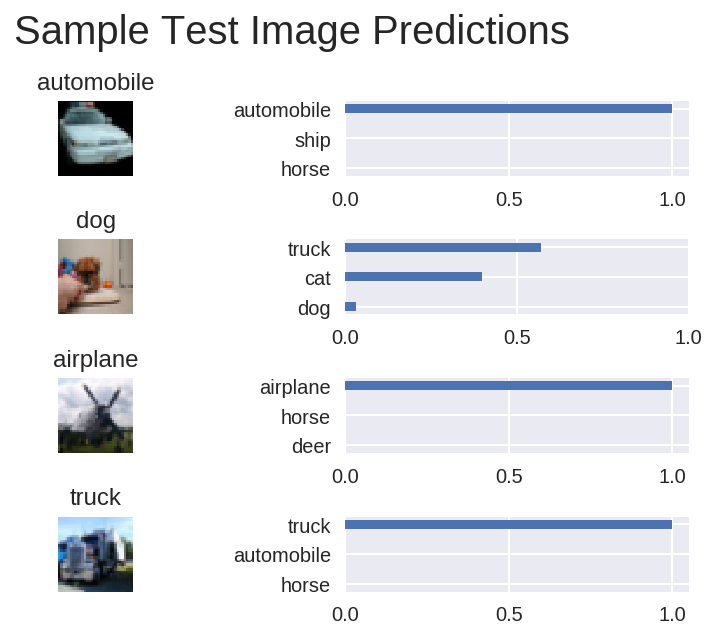

In [46]:
test_model()